In [33]:
#import neccessary Libraries and modules
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [34]:
'''
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)
'''

'\n# Detect hardware, return appropriate distribution strategy\ntry:\n    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()\n    print(\'Running on TPU \', tpu.master())\nexcept ValueError:\n    tpu = None\n\nif tpu:\n    tf.config.experimental_connect_to_cluster(tpu)\n    tf.tpu.experimental.initialize_tpu_system(tpu)\n    strategy = tf.distribute.experimental.TPUStrategy(tpu)\nelse:\n    strategy = tf.distribute.get_strategy() \n    # default distribution strategy in Tensorflow. Works on CPU and single GPU.\n\nprint("REPLICAS: ", strategy.num_replicas_in_sync)\n'

In [35]:
imagePatches = glob('../input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x451_y901_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x801_y451_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x151_y1051_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y901_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x701_y651_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x951_y1401_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x601_y501_cla

In [36]:
# Two arrays holding images by class type

class0 = [] # 0 = idc-
class1 = [] # 1 = idc+

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

In [37]:
len(class0)

198738

In [38]:
len(class1)

78786

In [39]:
import warnings
warnings.filterwarnings('ignore')

In [40]:
sampled_class0 = random.sample(class0, 10000)
sampled_class1 = random.sample(class1, 10000)
#len(sampled_class0)

In [41]:
from matplotlib.image import imread
import cv2

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (50, 50), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays


In [42]:
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)

In [43]:
class0_array[1]

[array([[[223, 215, 233],
         [222, 217, 231],
         [226, 214, 236],
         ...,
         [239, 238, 244],
         [228, 221, 231],
         [213, 199, 221]],
 
        [[242, 239, 240],
         [241, 238, 245],
         [210, 201, 228],
         ...,
         [241, 237, 239],
         [223, 216, 231],
         [234, 236, 242]],
 
        [[241, 239, 241],
         [241, 243, 243],
         [241, 239, 244],
         ...,
         [222, 216, 230],
         [242, 240, 244],
         [239, 241, 242]],
 
        ...,
 
        [[230, 229, 238],
         [221, 206, 232],
         [204, 188, 227],
         ...,
         [239, 239, 243],
         [240, 242, 242],
         [237, 239, 241]],
 
        [[230, 223, 235],
         [212, 200, 229],
         [209, 192, 230],
         ...,
         [243, 240, 240],
         [243, 238, 244],
         [241, 239, 241]],
 
        [[215, 202, 230],
         [213, 196, 227],
         [212, 199, 233],
         ...,
         [240, 240, 243],
  

In [44]:
test = cv2.imread('../input/breast-histopathology-images/IDC_regular_ps50_idx5/13689/1/13689_idx5_x801_y1501_class1.png' ,cv2.IMREAD_COLOR)
test.shape

(50, 50, 3)

In [45]:
from keras.preprocessing.image import load_img, img_to_array

In [46]:
def show_img(files):
    plt.figure(figsize= (10,10))
    ind = np.random.randint(0, len(files), 25)
    i=0
    for loc in ind:
        plt.subplot(5,5,i+1)
        sample = load_img(files[loc], target_size=(150,150))
        sample = img_to_array(sample)
        plt.axis("off")
        plt.imshow(sample.astype("uint8"))
        i+=1

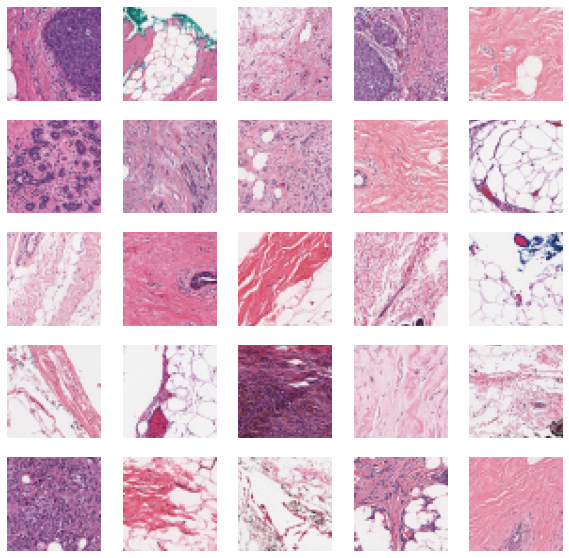

In [47]:
show_img(imagePatches)

In [48]:
combined_data = np.concatenate((class0_array, class1_array))
random.seed(42)
random.shuffle(combined_data)

In [49]:
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)

In [50]:
# print(X[11].reshape(-1, 50, 50, 3))
# reshape X data
X = np.array(X).reshape(-1, 50, 50, 3)

In [51]:
#Determine Shape of X
X.shape

(20000, 50, 50, 3)

In [52]:
#Splitting data into train and test data sets
X_train, X_test1, y_train, y_test1 = train_test_split(X, y, test_size=0.25, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test1, y_test1, test_size=0.25, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)
print(X_train.shape, X_test.shape, X_val, y_train.shape, y_test.shape, y_val.shape)

(15000, 50, 50, 3) (3750, 50, 50, 3) [[[[238 235 239]
   [239 236 237]
   [236 236 240]
   ...
   [154 108 176]
   [135  91 150]
   [147 105 169]]

  [[237 234 240]
   [240 234 239]
   [235 229 236]
   ...
   [153 110 172]
   [153  98 197]
   [146  96 196]]

  [[239 236 238]
   [236 237 237]
   [219 203 226]
   ...
   [162 114 194]
   [142  91 195]
   [151 105 184]]

  ...

  [[135  84 119]
   [160 125 157]
   [152 109 135]
   ...
   [169 144 162]
   [117  73  93]
   [182 156 183]]

  [[142  92 124]
   [175 131 171]
   [152 111 130]
   ...
   [170 136 153]
   [126  74 101]
   [125  82 115]]

  [[125  80 112]
   [134  99 115]
   [174 143 161]
   ...
   [176 138 159]
   [145 106 131]
   [167 144 159]]]


 [[[101  98  97]
   [ 94  90  88]
   [ 88  83  80]
   ...
   [ 89  87  87]
   [ 89  87  88]
   [ 89  87  89]]

  [[103 100  98]
   [ 96  92  90]
   [ 90  86  83]
   ...
   [ 88  86  86]
   [ 88  86  87]
   [ 88  86  87]]

  [[108 104 102]
   [102  97  93]
   [ 96  92  89]
   ...
   [ 87 

In [53]:
#Crating a Convolutional Neural Network

def create_model():        
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(50,50,3)))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(2, activation="softmax"))
    adam = Adam(learning_rate=0.0001)
    #binary_crossentropy is used as Cancer detecion is  binary classification model
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=['accuracy'])   

    return model

In [54]:
#with strategy.scope():
model = create_model()
#Training and Testing the CNN 
#epochs determines no of times learning algorithm walks through the dataset
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs= 20,
    verbose = 2,
)



Epoch 1/20
469/469 - 2s - loss: 1.2440 - accuracy: 0.8421 - val_loss: 0.3533 - val_accuracy: 0.8640
Epoch 2/20
469/469 - 2s - loss: 0.3285 - accuracy: 0.8783 - val_loss: 0.3976 - val_accuracy: 0.8656
Epoch 3/20
469/469 - 2s - loss: 0.2697 - accuracy: 0.9034 - val_loss: 0.3066 - val_accuracy: 0.8899
Epoch 4/20
469/469 - 2s - loss: 0.2092 - accuracy: 0.9288 - val_loss: 0.3181 - val_accuracy: 0.8987
Epoch 5/20
469/469 - 2s - loss: 0.1678 - accuracy: 0.9445 - val_loss: 0.3024 - val_accuracy: 0.8997
Epoch 6/20
469/469 - 2s - loss: 0.1325 - accuracy: 0.9579 - val_loss: 0.3291 - val_accuracy: 0.9125
Epoch 7/20
469/469 - 2s - loss: 0.1044 - accuracy: 0.9693 - val_loss: 0.3761 - val_accuracy: 0.9088
Epoch 8/20
469/469 - 2s - loss: 0.0823 - accuracy: 0.9771 - val_loss: 0.3479 - val_accuracy: 0.9136
Epoch 9/20
469/469 - 2s - loss: 0.0594 - accuracy: 0.9843 - val_loss: 0.3510 - val_accuracy: 0.9171
Epoch 10/20
469/469 - 2s - loss: 0.0499 - accuracy: 0.9869 - val_loss: 0.4377 - val_accuracy: 0.9115

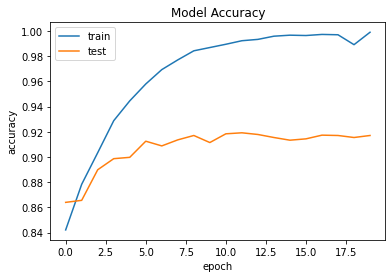

In [55]:
#plotting the Accuracy of test and training sets
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

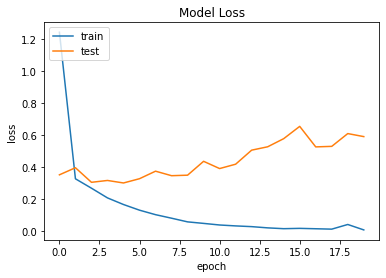

In [56]:
#plotting the loss of test and training sets
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [57]:
import seaborn as sns
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
def get_accuracy_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    y_train=np.argmax(y_train, axis=1)
    y_test=np.argmax(y_test, axis=1)
    y_val=np.argmax(y_val, axis=1)
    y_train_pred=np.argmax(model.predict(X_train),axis=1)
    y_test_pred=np.argmax(model.predict(X_test),axis=1)
    y_val_pred=np.argmax(model.predict(X_val),axis=1)
    print("Train accuracy Score------------>")
    print ("{0:.3f}".format(accuracy_score(y_train, y_train_pred)*100), "%")
    
    print("Val accuracy Score--------->")
    
    print("{0:.3f}".format(accuracy_score(y_val, y_val_pred)*100), "%")
    
  
    print("Test accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(y_test, y_test_pred)*100), "%")
    
    print("F1 Score--------------->")
    print("{0:.3f}".format(f1_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    print("Cohen Kappa Score------------->")
    print("{0:.3f}".format(cohen_kappa_score(y_test, y_test_pred)*100), "%")
    
    print("Recall-------------->")
    print("{0:.3f}".format(recall_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    print("Precision-------------->")
    print("{0:.3f}".format(precision_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    cf_matrix_test = confusion_matrix(y_test, y_test_pred)
    cf_matrix_val = confusion_matrix(y_val, y_val_pred)
    
    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
    plt.title("Val Confusion matrix")
    
    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
    plt.title("Test Confusion matrix")
    
    plt.show()

Train accuracy Score------------>
99.973 %
Val accuracy Score--------->
92.400 %
Test accuracy Score--------->
91.707 %
F1 Score--------------->
91.383 %
Cohen Kappa Score------------->
66.743 %
Recall-------------->
91.707 %
Precision-------------->
91.304 %


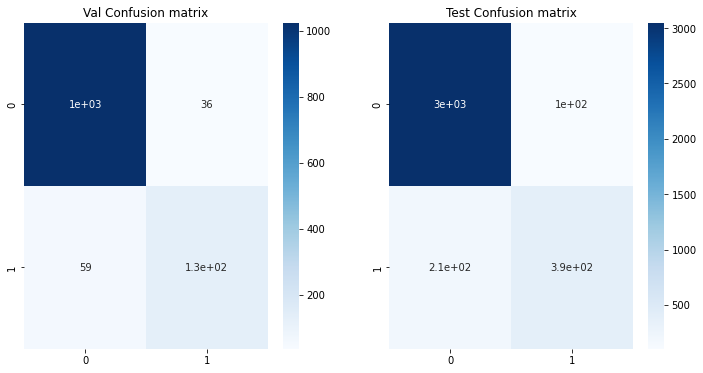

In [58]:
get_accuracy_metrics(model,  X_train, y_train, X_val, y_val, X_test, y_test)